# Import Modules

## Standard Packages

In [1]:
import os
import sys
import os.path as path
import psutil
import glob
import random
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
#plt.style.use('seaborn-white')
from datetime import date, datetime, timedelta, time
from timeit import default_timer as timer
import time

## Scikit-Learn

In [2]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report


## User-Defined Functions

In [3]:
from TrainModel_Helper import *
from Extract_DFM_Reanalysis_Data_Helper import *

# Global Start Time and Memory

In [4]:
global_start_time = timer()
process = psutil.Process(os.getpid())
global_initial_memory = process.memory_info().rss

# Variables to be Used for Preparing Train, Test, and Fire Data

## DataSet Defintion

In [5]:
# The current data set params
data_set_count = 1

## Define Model, Label etc.

### Label Type

In [6]:
label_type = 'MC' # ['bin', 'MC', 'Regr']

In [7]:
FM_hr = 10 # [10, 100]

### Models 

In [8]:
model_considered = 'MLP' # ['RF', SVM', 'MLP']

### Fire of Interest

In [9]:
fire_name = 'Woosley'

## Paths and File Names

#### Global

In [10]:
prepared_data_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/02_TrainTestFire_Data_Prepared'
trained_model_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/03_Trained_Models'
analysis_data_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/04_Analysis'

#### DataSet Specific (Train, Test, Fire Prepared)

In [11]:
prepared_data_set_name = 'data_prepared_%02d'%(data_set_count)

prepared_data_loc = os.path.join(prepared_data_base_loc, prepared_data_set_name)
os.system('mkdir -p %s'%prepared_data_loc)

prepared_data_file_name = '{}.pkl'.format(prepared_data_set_name)

#### DataSet Specific (Trained Model)

In [12]:
trained_model_set_name = 'trained_model_%02d'%(data_set_count)

trained_model_loc = os.path.join(trained_model_base_loc, trained_model_set_name)
os.system('mkdir -p %s'%trained_model_loc)

trained_model_name = '{}_{}_{}.pkl'.format(trained_model_set_name, label_type, model_considered)
trained_model_file = os.path.join(trained_model_loc, trained_model_name)

#### DataSet Specific (Analysis Data)

In [13]:
analysis_set_name = 'analysis_%02d'%(data_set_count)

analysis_loc = os.path.join(analysis_data_base_loc, analysis_set_name, label_type, model_considered)
os.system('mkdir -p %s'%analysis_loc)

0

# Generate seed for the random number generator

In [14]:
seed = generate_seed()
random_state = init_random_generator(seed)

# Load The The Prepared Data Saved in Pickle File

In [15]:
prepared_data_file_handle = open(os.path.join(prepared_data_loc, prepared_data_file_name), 'rb')
prepared_data = pickle.load(prepared_data_file_handle)
prepared_data_file_handle.close()
print('Read prepared data from "{}" at "{}"'.format(prepared_data_file_name, prepared_data_loc))

Read prepared data from "data_prepared_07.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/02_TrainTestFire_Data_Prepared/data_prepared_07"


# Get Features and Labels to Use

In [16]:
#prepared_data['tt']['all']
#prepared_data['fire']['Woosley']['identity'].head(5)

## Get the Headers for Features and Labels

In [17]:
features_to_use = prepared_data['tt']['features'].keys()
if (label_type == 'Regr'):
    label_to_use = 'FM_{}hr'.format(FM_hr)
else:
    label_to_use = 'FM_{}hr_{}'.format(FM_hr, label_type)

## Extract Features and Labels

In [18]:
X_tt     = prepared_data['tt']['features'][features_to_use]
y_tt     = prepared_data['tt']['labels'][label_to_use]
idy_tt   = prepared_data['tt']['identity']

X_fire   = prepared_data['fire'][fire_name]['features'][features_to_use]
y_fire   = prepared_data['fire'][fire_name]['labels'][label_to_use]
idy_fire = prepared_data['fire'][fire_name]['identity']

#all = prepared_data['tt']['all']

In [19]:
y_tt

0         3
1         0
2         8
3         6
4         5
         ..
199995    7
199996    7
199997    6
199998    6
199999    5
Name: FM_10hr_MC, Length: 200000, dtype: int64

## Scale Features

#### Features for Train/Test

In [20]:
scaler = MinMaxScaler()
scaler.fit(X_tt)
X_tt_scaled = scaler.transform(X_tt)

In [21]:
#X_tt_scaled

#### Features for Fire Data

In [22]:
scaler = MinMaxScaler()
scaler.fit(X_fire)
X_fire_scaled = scaler.transform(X_fire)

In [23]:
#X_fire_scaled.max()

## Train /Test Split

In [24]:
features_train, features_test, labels_train, labels_test = train_test_split(X_tt_scaled, y_tt, test_size=0.2)

# Model

## Define the Model

In [ ]:
print ('label_type: {}'.format(label_type))
print ('Model: {}'.format(model_considered))

if (label_type == 'Regr'):
    match model_considered:
        case 'SVM':
            model = SVR(kernel='rbf')
        case 'RF':
            model = RandomForestRegressor(max_depth=2, random_state=0)
        case 'MLP':
            model = MLPRegressor(random_state=1, max_iter=500)
else: # 'bin' or 'MC'
    match model_considered:
        case 'SVM':
            model = SVC(kernel="linear", class_weight = "balanced")
        case 'RF':
            model = RandomForestClassifier(max_depth=2, random_state=0)
        case 'MLP':
            model = MLPClassifier(solver = 'sgd', activation = 'relu', max_iter= 10000, 
                    random_state = 0, hidden_layer_sizes = [15,15,15])


In [ ]:
model

## Train the Model

In [ ]:
t0 = time.time()
model.fit(features_train, labels_train)
print ("Training Time:", round(time.time()-t0, 3), "s")

## Save the Model

In [ ]:
pickle.dump(model, open(trained_model_file, 'wb'))

## Load the Model

In [25]:
trained_model_file

'/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/03_Trained_Models/trained_model_07/trained_model_07_MC_MLP.pkl'

In [26]:
model = pickle.load(open(trained_model_file, 'rb'))

In [27]:
model

MLPClassifier(hidden_layer_sizes=[15, 15, 15], max_iter=10000, random_state=0,
              solver='sgd')

# Prediction with Trained Model

## Prediction on Train Data

In [28]:
t1 = time.time()
labels_pred = model.predict(features_train)
print ("Prediction Time:", round(time.time()-t1, 3), "s")

accuracy = accuracy_score(labels_pred, labels_train)
conf_mat = None

if (label_type == 'bin'):
    conf_mat = confusion_matrix(labels_train, labels_pred, labels = [0, 1])
    print('Classification Report: \n')
    print(classification_report(labels_train, labels_pred, labels=[0, 1]))
    average_precision = average_precision_score(labels_train, labels_pred)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
elif (label_type == 'MC'):
    conf_mat = confusion_matrix(labels_train, labels_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
else:
    print('label_type: {} is unrecognized'.format(label_type))

print('Accuracy Score: {}'.format(accuracy))
print('Confusion Matrix: \n{}'.format(conf_mat))

Prediction Time: 0.678 s
Accuracy Score: 0.37190625
Confusion Matrix: 
[[  334  5595  1554   457   112   334    62    11    15     1]
 [  151 19037  7841  1238   240   519    69    20    18     2]
 [   53  9152 15063  4342   754  1452   150    51    34     3]
 [    7  2568  8120  7302  1856  3630   446    82   109     2]
 [    6   745  2936  5296  2470  6965   733   163   164     5]
 [    3   321  1144  3025  2179 10572  1682   360   387     6]
 [    3   110   400  1064   650  5992  2161   605   833     9]
 [    1    29   191   447   202  2576  1799   835  1281    10]
 [    0    11   141   351   129  1579  1251   775  1718    11]
 [    0    10    84   188    61   711   389   312  1120    13]]


## Prediction on Test Data

In [29]:
t1 = time.time()
labels_pred = model.predict(features_test)
print ("Prediction Time:", round(time.time()-t1, 3), "s")

accuracy = accuracy_score(labels_pred, labels_test)

if (label_type == 'bin'):
    conf_mat = confusion_matrix(labels_test, labels_pred, labels = [0, 1])
    print('Classification Report: \n')
    print(classification_report(labels_test, labels_pred, labels=[0, 1]))
    average_precision = average_precision_score(labels_test, labels_pred)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
elif (label_type == 'MC'):
    conf_mat = confusion_matrix(labels_test, labels_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
else:
    print('label_type: {} is unrecognized'.format(label_type))

print('Accuracy Score: {}'.format(accuracy))
print('Confusion Matrix: \n{}'.format(conf_mat))

Prediction Time: 0.027 s
Accuracy Score: 0.37345
Confusion Matrix: 
[[ 100 1444  377   89   26   91   21    2    1    0]
 [  39 4760 1961  283   50  106   13    7    5    2]
 [  20 2230 3803 1103  178  335   48   12   20    2]
 [   4  650 1948 1821  519  849   97   10   17    2]
 [   1  177  738 1328  584 1682  177   41   47    1]
 [   1   70  303  825  539 2682  406   93   89    1]
 [   0   23  114  271  144 1528  565  168  217    0]
 [   0   10   59  133   42  643  473  227  322    3]
 [   0    6   42   73   30  403  331  192  392    2]
 [   0    5   22   50   17  195   89   89  286    4]]


## Prediction on Fire Data

In [30]:
t1 = time.time()
labels_pred = model.predict(X_fire_scaled)
print ("Prediction Time:", round(time.time()-t1, 3), "s")

accuracy = accuracy_score(labels_pred, y_fire)

if (label_type == 'bin'):
    conf_mat = confusion_matrix(y_fire, labels_pred, labels = [0, 1])
    print('Classification Report: \n')
    print(classification_report(y_fire, labels_pred, labels=[0, 1]))
    average_precision = average_precision_score(y_fire, labels_pred)
    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))
elif (label_type == 'MC'):
    conf_mat = confusion_matrix(y_fire, labels_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
else:
    print('label_type: {} is unrecognized'.format(label_type))

print('Accuracy Score: {}'.format(accuracy))
print('Confusion Matrix: \n{}'.format(conf_mat))

Prediction Time: 0.08 s
Accuracy Score: 0.4737304095247215
Confusion Matrix: 
[[   34    81   706   137     0   185     0     0     0    53]
 [ 8727 21652  9630  1113     5   368     0     0     0   160]
 [ 5722 22514 33515 10995    65   925     1     0     2   286]
 [  119   162  3711  4163    50   214     3     0     6     3]
 [    0     0     0     0     2     7     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]]


## Plot Ground Truth and Prediction of Fire Data

In [31]:
ny, nx = (480, 396)
j_indices = idy_fire['j_ind']
i_indices = idy_fire['i_ind']
ground_truth = y_fire

In [32]:
if label_type == 'Regr':
    ground_truth_mat = np.full((ny,nx), np.nan)
    pred_mat = np.full_like(ground_truth_mat, np.nan )
    error_mat = np.full_like(ground_truth_mat, np.nan)
else:
    ground_truth_mat = np.ones((ny,nx), int)*(-1)
    pred_mat = np.ones_like(ground_truth_mat, int)*(-1)
    error_mat = np.ones_like(ground_truth_mat, int)*(-1)

In [33]:
for j_loc, i_loc, gt_val, pred_val in zip (j_indices, i_indices, ground_truth, labels_pred):
    ground_truth_mat[j_loc][i_loc] = gt_val
    pred_mat[        j_loc][i_loc] = pred_val
    error_mat[       j_loc][i_loc] = (gt_val == pred_val)

In [34]:
error_mat

array([[-1, -1, -1, ...,  0,  0,  0],
       [-1, -1, -1, ...,  0,  0,  1],
       [-1, -1, -1, ...,  1,  0,  1],
       ...,
       [-1, -1, -1, ...,  1,  1,  0],
       [-1, -1, -1, ...,  1,  1,  0],
       [-1, -1, -1, ...,  0,  0,  0]])

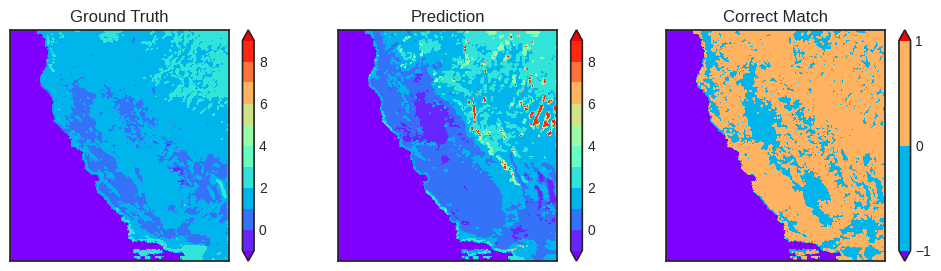

In [35]:
cmap_name = 'rainbow'
cont_levels = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

x_ind, y_ind = np.meshgrid(range(nx), range(ny))

cont = ax[0].contourf(x_ind, y_ind, ground_truth_mat, levels = cont_levels, cmap=cmap_name, extend='both')
plt.colorbar(cont)
ax[0].set_title('Ground Truth')
ax[0].set_xticks([])
ax[0].set_yticks([])

cont = ax[1].contourf(x_ind, y_ind, pred_mat, levels = cont_levels, cmap=cmap_name, extend='both')
plt.colorbar(cont)
ax[1].set_title('Prediction')
ax[1].set_xticks([])
ax[1].set_yticks([])

cont = ax[2].contourf(x_ind, y_ind, error_mat, levels = [-1, 0, 1], cmap=cmap_name, extend='both')
plt.colorbar(cont)
ax[2].set_title('Correct Match')
ax[2].set_xticks([])
ax[2].set_yticks([])

filename = trained_model_name.split('.')[0] + '_{}_Fire.png'.format(fire_name)
filedir = analysis_loc
os.system('mkdir -p %s'%filedir)

plt.savefig(os.path.join(filedir, filename), bbox_inches='tight')

# Global End Time and Memory

In [ ]:
global_final_memory = process.memory_info().rss
global_end_time = timer()
global_memory_consumed = global_final_memory - global_initial_memory
print('Total memory consumed: {:.3f} MB'.format(global_memory_consumed/(1024*1024)))
print('Total computing time: {:.3f} s'.format(global_end_time - global_start_time))
print('=========================================================================')
print("SUCCESS: Done Training and Testing of Model")